# **03 - CorrelationStudy**

## Objectives

* Identify the house attributes that correlate with the target variable: `SalePrice`

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Data plots/visualizations for the Streamlit app. (Business Requirement 1)
* docs/plots/box_plot_price_by_KitchenQual.png
* docs/plots/box_plot_price_by_OverallQual.png
* docs/plots/heatmap_corr_pearson.png
* docs/plots/heatmap_corr_spearman.png
* docs/plots/heatmap_pps.png
* docs/plots/hist_plot_SalePrice.png
* docs/plots/line_plot_price_by_YearBuilt.png
* docs/plots/line_plot_price_by_YearRemodAdd.png
* docs/plots/lm_plot_price_by_1stFlrSF.png
* docs/plots/lm_plot_price_by_GarageArea.png
* docs/plots/lm_plot_price_by_GrLivArea.png
* docs/plots/lm_plot_price_by_MasVnrArea.png
* docs/plots/lm_plot_price_by_OpenPorchSF.png
* docs/plots/lm_plot_price_by_TotalBsmtSF.png

## Additional Comments

* 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/property-value-maximizer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/property-value-maximizer'

Uses pandas library to load dataset into DataFrames df and displays the first 10 rows of the dataset.

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,706,150,548,1710,Gd,8450,65.000000,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,978,284,460,1262,TA,9600,80.000000,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,486,434,608,1786,Gd,11250,68.000000,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.888787,216,540,642,1717,Gd,9550,60.000000,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,655,490,836,2198,Gd,14260,84.000000,350.0,84,5,8,1145,2000,2000,250000
5,796,566.0,1.000000,732,64,480,1362,TA,14115,85.000000,0.0,30,5,5,796,1993,1995,143000
6,1694,0.0,3.000000,1369,317,636,1694,Gd,10084,75.000000,186.0,57,5,8,1686,2004,2005,307000
7,1107,983.0,3.000000,859,216,484,2090,TA,10382,70.343849,240.0,204,6,7,1107,1973,1973,200000
8,1022,752.0,2.000000,0,952,468,1774,TA,6120,51.000000,0.0,0,5,7,952,1931,1950,129900
9,1077,0.0,2.000000,851,140,205,1077,TA,7420,50.000000,0.0,4,6,5,991,1939,1950,118000


Generates an exploratory data analysis (EDA) report of Dataframe df.

In [5]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df=df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Applies one-hot encoding to categorical variables in DataFrame df.

In [6]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(5)

(1460, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,LotArea,LotFrontage,MasVnrArea,...,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.000000,706,150,548,1710,8450,65.0,196.0,...,5,7,856,2003,2003,208500,1,0,0,0
1,1262,0.0,3.000000,978,284,460,1262,9600,80.0,0.0,...,8,6,1262,1976,1976,181500,0,1,0,0
2,920,866.0,3.000000,486,434,608,1786,11250,68.0,162.0,...,5,7,920,2001,2002,223500,1,0,0,0
3,961,0.0,2.888787,216,540,642,1717,9550,60.0,0.0,...,5,7,756,1915,1970,140000,1,0,0,0
4,1145,0.0,4.000000,655,490,836,2198,14260,84.0,350.0,...,5,8,1145,2000,2000,250000,1,0,0,0


 Create a new directory called "docs/plots".

In [7]:
import os

try:
  os.makedirs("docs/plots")
except Exception as e:
  print(e)

[Errno 17] File exists: 'docs/plots'


Defines several functions to calculate and visualize relationships between features in a dataset using correlations and Power Predictive Score (PPS).

In [8]:
import numpy as np
import ppscore as pps
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline


def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  """
  Function to create heatmap using correlations.
  """
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    if df.name == "corr_spearman":
      plt.savefig(f'docs/plots/heatmap_corr_spearman.png', bbox_inches='tight')
    else:
      plt.savefig(f'docs/plots/heatmap_corr_pearson.png', bbox_inches='tight')
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    """
    Function to create heatmap using pps.
    """
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.savefig(f'docs/plots/heatmap_pps.png', bbox_inches='tight')
      plt.show()


def CalculateCorrAndPPS(df):
  """
  Function to calculate correlations and pps.
  """
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):
  """
  Function to display the correlations and pps.
  """

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Suppresses FutureWarnings and calls the CalculateCorrAndPPS function on the DataFrame df_ohe, which computes both Spearman and Pearson correlation matrices, as well as the Power Predictive Score (PPS) matrix. The results are stored in the variables df_corr_pearson, df_corr_spearman, and pps_matrix for further analysis or visualization.

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_ohe)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count  mean    std  min  25%  50%    75%    max
ppscore  420.0  0.04  0.092  0.0  0.0  0.0  0.034  0.677


Calls the DisplayCorrAndPPS function to visualize the correlation and Power Predictive Score (PPS) matrices.



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



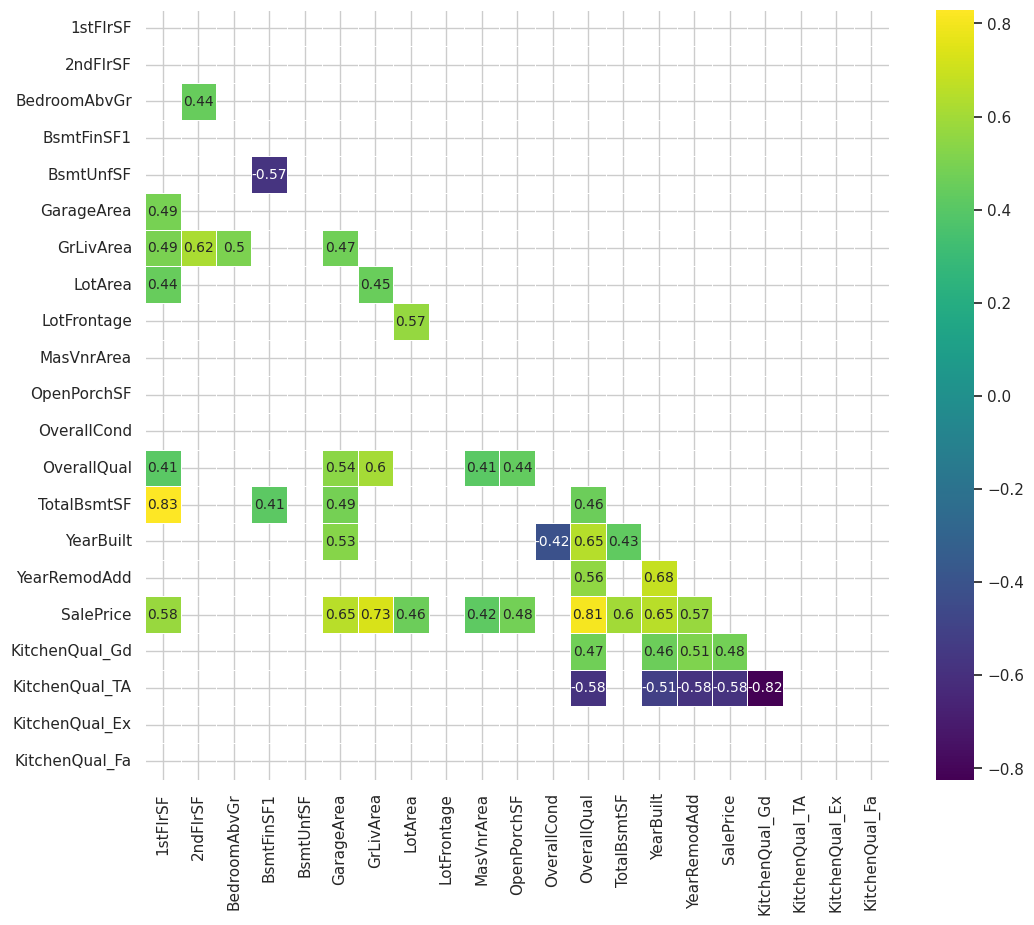



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



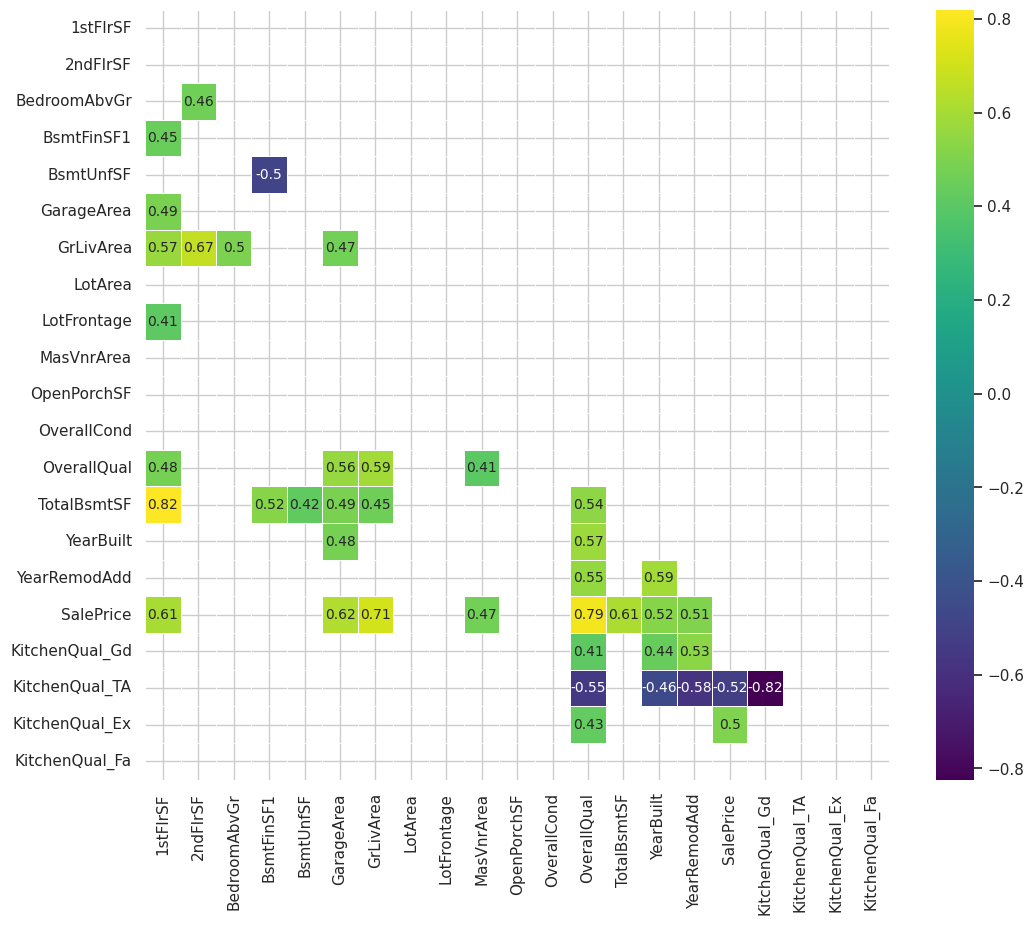



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



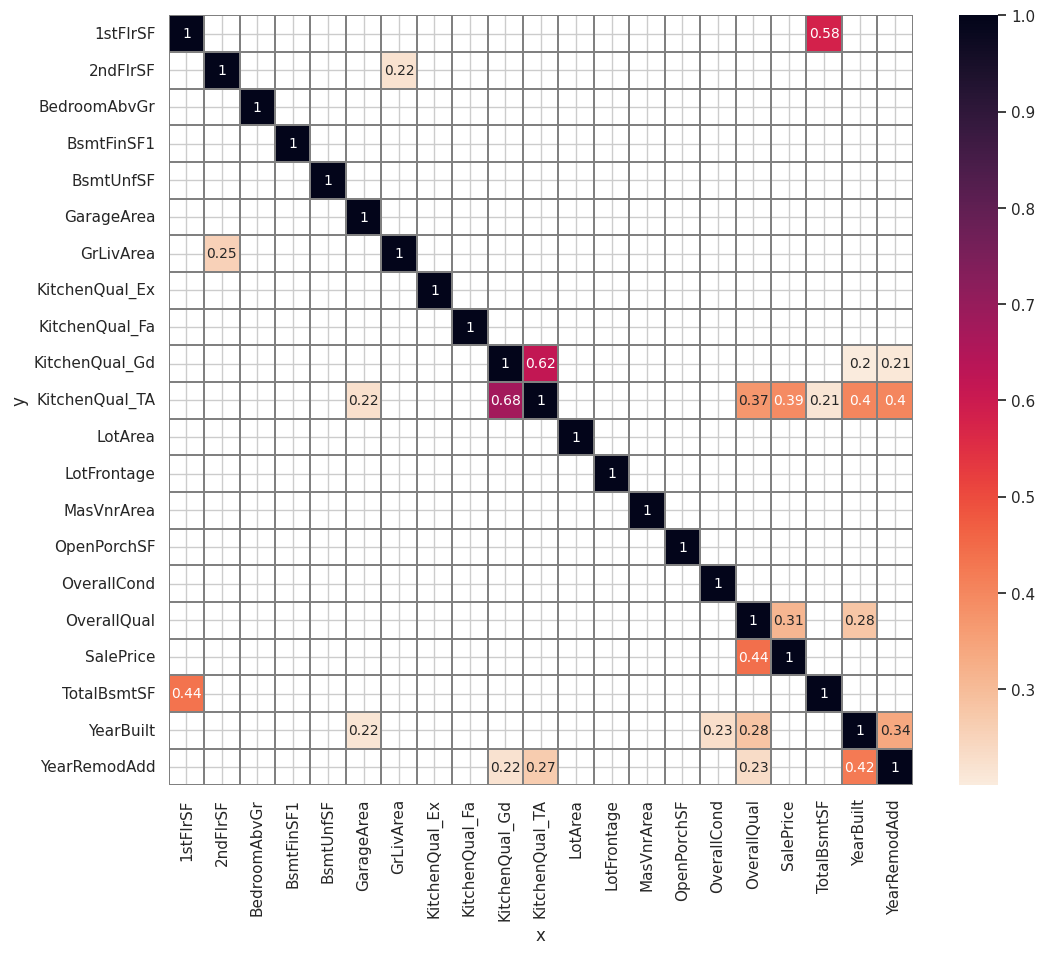

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

Calculates the Spearman correlation coefficients between all columns in the df_ohe DataFrame and the target variable `SalePrice`

In [11]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
OpenPorchSF       0.477561
Name: SalePrice, dtype: float64

Calculates the Pearson correlation coefficients between all columns in the df_ohe DataFrame and the target variable `SalePrice`

In [12]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64

Creates a set containing the top 10 features most strongly correlated with `SalePrice`

In [13]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

Defines a list called vars_to_study that contains variables which are considered important for further analysis.

In [14]:
vars_to_study = [
    '1stFlrSF',
    'GarageArea',
    'GrLivArea',
    'KitchenQual',
    'MasVnrArea',
    'OpenPorchSF',
    'OverallQual',
    'TotalBsmtSF',
    'YearBuilt',
    'YearRemodAdd'
]
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

Creates a new DataFrame called df_eda by filtering the original df DataFrame to include only the columns specified in the vars_to_study and target variable `SalePrice`

In [15]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head()

,1stFlrSF,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,548,1710,Gd,196.0,61,7,856,2003,2003,208500
1,1262,460,1262,TA,0.0,0,6,1262,1976,1976,181500
2,920,608,1786,Gd,162.0,42,7,920,2001,2002,223500
3,961,642,1717,Gd,0.0,35,7,756,1915,1970,140000
4,1145,836,2198,Gd,350.0,84,8,1145,2000,2000,250000


Defines a function to create and save a histogram of the `SalePrice` distribution with a KDE overlay.

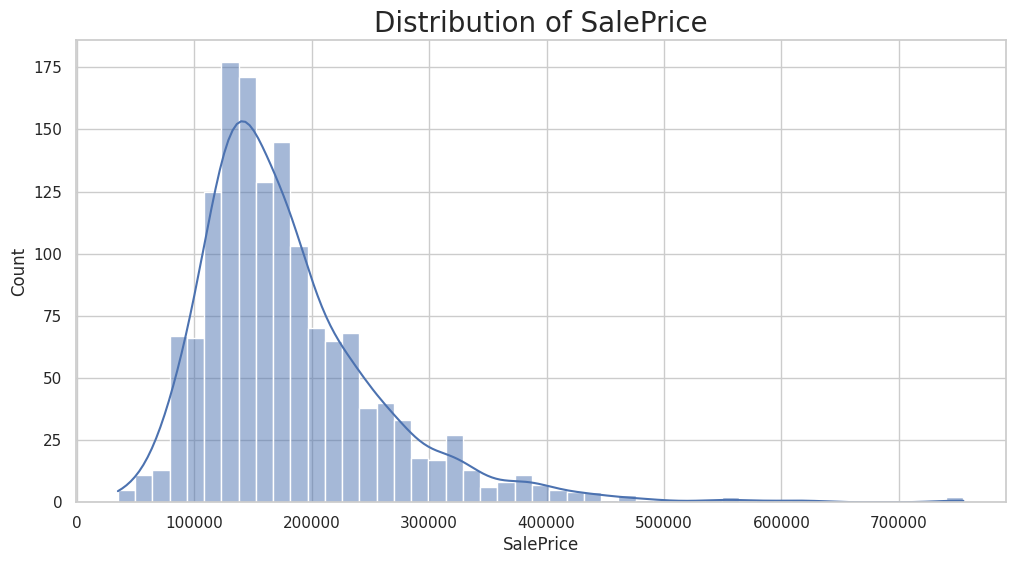

In [16]:
sns.set_style('whitegrid')
target_var = 'SalePrice'

def plot_target_hist(df, target_var):
  """
  Function to create histogram of the values of target.
  Save histogram into docs/plots for use in dashboard
  """
  plt.figure(figsize=(12, 6))
  sns.histplot(data=df, x=target_var, kde=True)
  plt.title(f"Distribution of {target_var}", fontsize=20)
  plt.savefig(f'docs/plots/hist_plot_{target_var}.png', bbox_inches='tight')        
  plt.show()

plot_target_hist(df, target_var)

Defines three functions to visualize the relationship between the target variable `SalePrice` and various features.

<Figure size 1200x500 with 0 Axes>

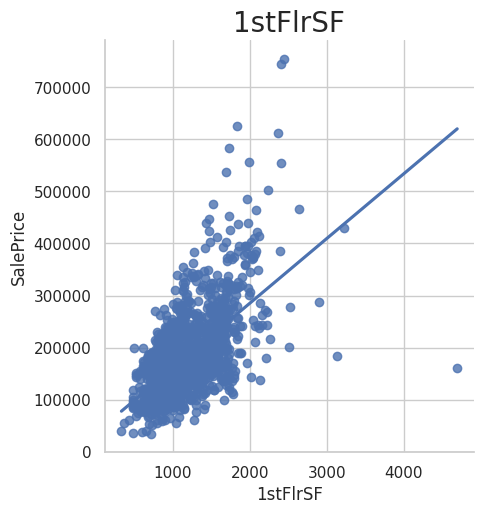

<Figure size 1200x500 with 0 Axes>

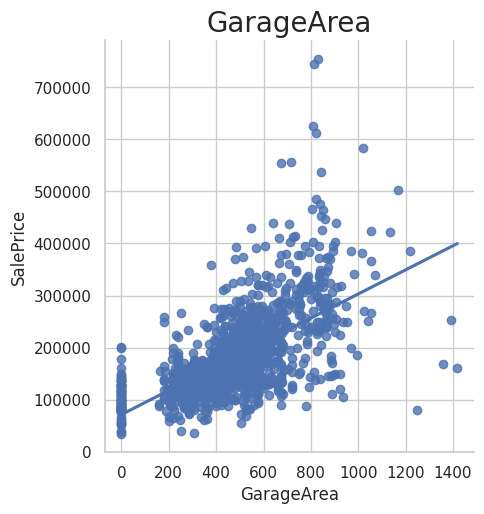

<Figure size 1200x500 with 0 Axes>

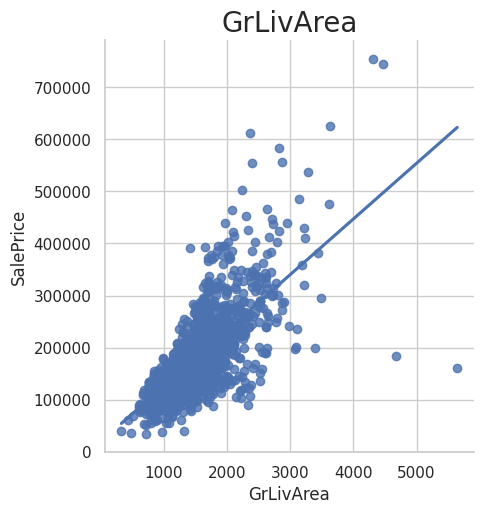

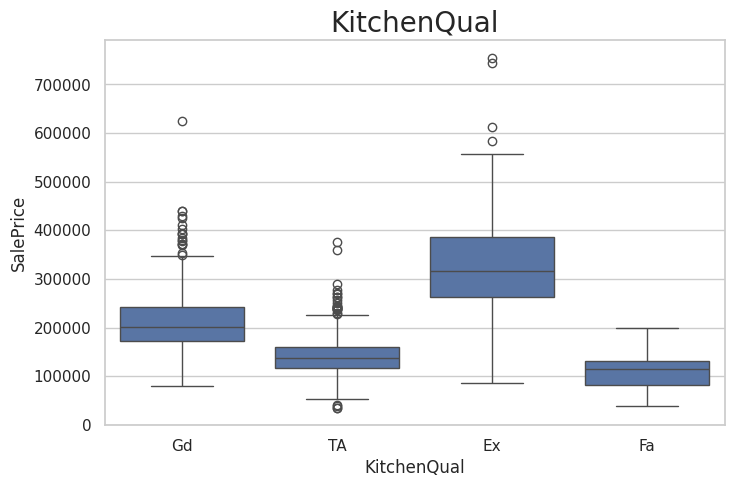

<Figure size 1200x500 with 0 Axes>

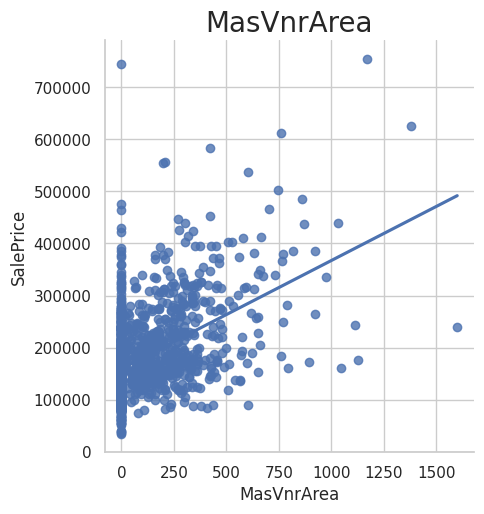

<Figure size 1200x500 with 0 Axes>

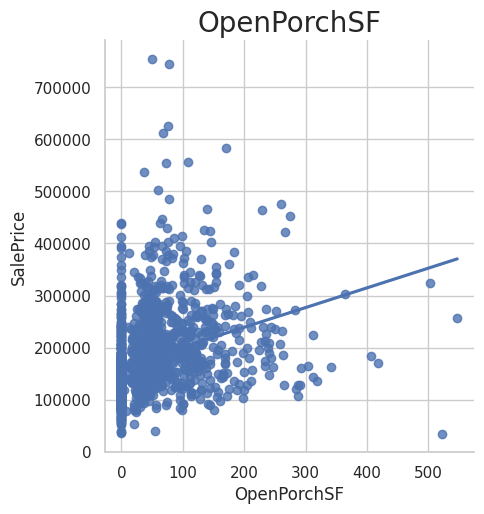

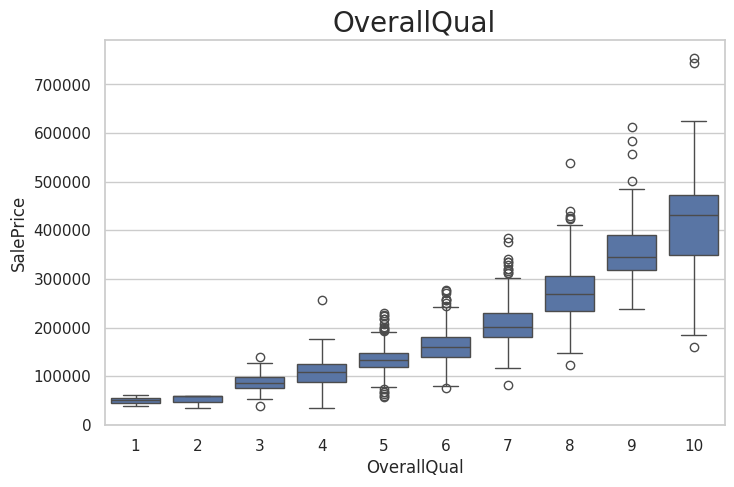

<Figure size 1200x500 with 0 Axes>

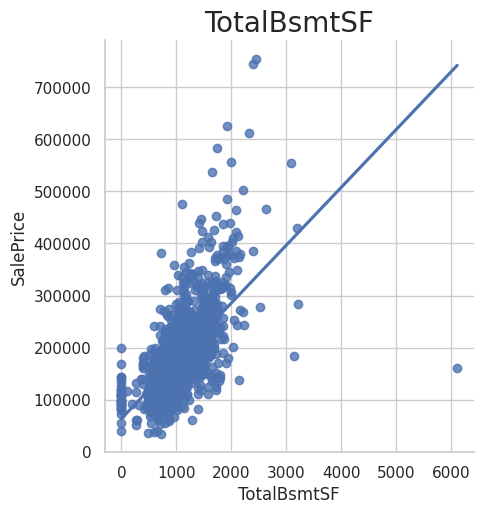

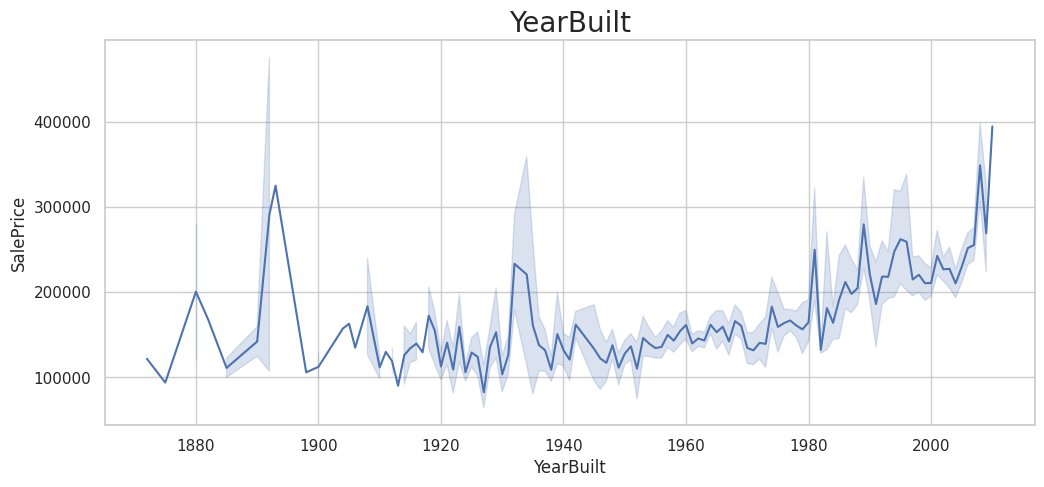

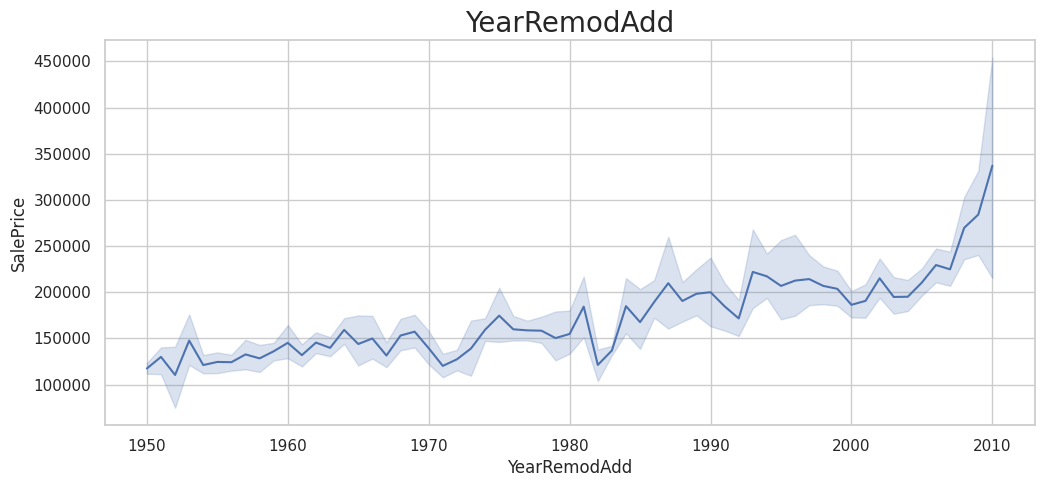

In [17]:
time = ['YearBuilt', 'YearRemodAdd']

def plot_lm(df, col, target_var):
  """
  Function to create linear regression plots of the target and
  features with continuous values.
  Figures created saved to folder docs/plots
  """
  plt.figure(figsize=(12, 5))
  sns.lmplot(data=df, x=col, y=target_var, ci=None)
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/lm_plot_price_by_{col}.png', bbox_inches='tight')        
  plt.show()

def plot_line(df, col, target_var):
  """
  Function creates a line plot of the target and time variables.
  Figures created saved to folder docs/plots
  """
  plt.figure(figsize=(12, 5))
  sns.lineplot(data=df, x=col, y=target_var)
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/line_plot_price_by_{col}.png', bbox_inches='tight')        
  plt.show()

def plot_box(df, col, target_var):
  """
  Function creates a box plot of the target versus categorical variables.
  Figures created saved to folder docs/plots
  """
  plt.figure(figsize=(8, 5))
  sns.boxplot(data=df, x=col, y=target_var) 
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/box_plot_price_by_{col}', bbox_inches='tight')
  plt.show()


for col in vars_to_study:
  if len(df_eda[col].unique()) <= 10:
    plot_box(df_eda, col, target_var)
    print("\n\n")
  else:
    if col in time:
      plot_line(df_eda, col, target_var)
      print("\n\n")
    else:
      plot_lm(df_eda, col, target_var)
      print("\n\n")